# Import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles,Heatmap, LayersControl
from random import uniform
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
pd.set_option('float_format', '{:f}'.format)

We created two datframes for our EDA:

- df   - the original, ternary classification
    - this is used only in the initial target class analysis
    - we determined the three classes were far too unbalanced
    
- df_b - binary classification
    - used for EDA

In [9]:
df = pd.read_csv('../data/cleaned_water_EDA.csv',index_col=0)

df_b = df.copy()
df_b['status_group'] = df_b['status_group'].replace(to_replace =["functional needs repair", "non functional"],value ="needs repair")
df.amount_tsh = df.amount_tsh.astype('int64')
df_b.amount_tsh = df_b.amount_tsh.astype('int64')

---
# Notebook structure

Each feature analyzed will have the following:

- Value counts (binned if relevent)
- a crossbar table with across the target classes
- a bar plot

---
# Target Analysis

Status Group

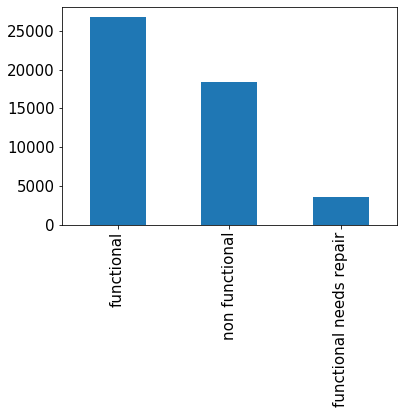

In [10]:
df.status_group.value_counts().plot(kind='bar',fontsize=15)

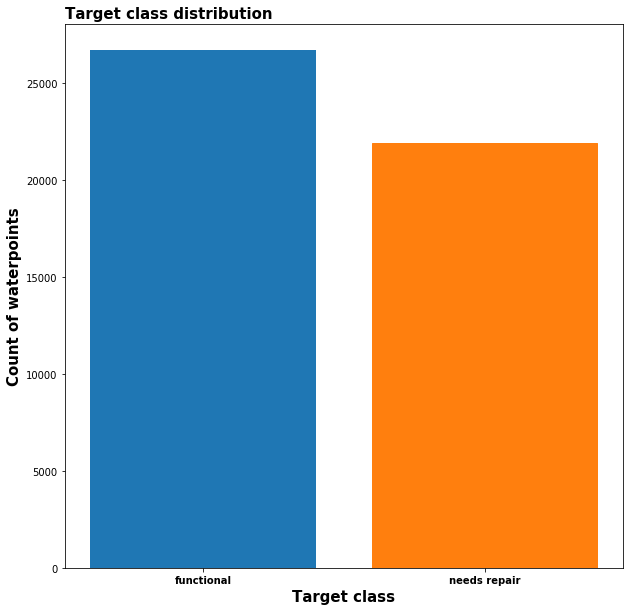

In [12]:
statuses = df_b.status_group.value_counts().index
counts = df_b.status_group.value_counts().values
plt.figure(figsize=(10,10)) 

ax1 = plt.bar(statuses, counts)
#plt.text(0.05, 0.95, '23', transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)


plt.title('Target class distribution',fontweight='bold',fontsize=15,loc='left')
plt.xlabel("Target class",fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold')
plt.ylabel("Count of waterpoints",fontweight='bold',fontsize=15)

ax1[-1].set_color('C1') 
#ax1[-3].set_color('rebeccapurple')#this is indicating an Action/adventure film ^^ VV


#plt.gcf().subplots_adjust(bottom=0.15,left=0.25)

plt.savefig('../images/status.png',bbox_inches='tight',pad_inches=0.5)
plt.show()

- We identified a cluster of waterpoint observations with latitude and longitude that mapped them outside of Tanzania; these observations have the same age of 23 years and one coordinate (effectively 0,0)
- These observations will be obtained for modeling but cannot be included in any potential geographic plots .

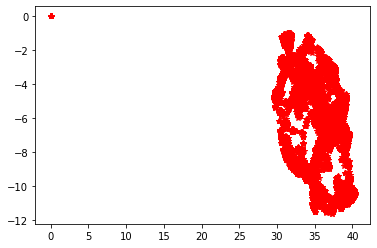

In [13]:
plt.plot(df_b.longitude, df_b.latitude,'r*')

Trying to understand these waterpoints a bit...

In [7]:
df_g = df_b[df_b['longitude'] < 27.5]

In [8]:
df_g.longitude.value_counts()

0.000000    1326
Name: longitude, dtype: int64

In [9]:
df_g.latitude.value_counts()

-0.000000    1326
Name: latitude, dtype: int64

In [10]:
df_g.status_group.value_counts()

needs repair    740
functional      586
Name: status_group, dtype: int64

In [11]:
df_g.basin.value_counts()

Lake Victoria      1227
Lake Tanganyika      99
Name: basin, dtype: int64

In [12]:
#df_g.district_code.value_counts()

In [13]:
df_g.region.value_counts()

Shinyanga    696
Mwanza       630
Name: region, dtype: int64

In [14]:
df_g.payment_type.value_counts()

never pay     856
unknown       152
other         146
monthly        66
on failure     58
per bucket     32
annually       16
Name: payment_type, dtype: int64

In [15]:
df_g.age.value_counts() #they were constructed the same year!?

23    1326
Name: age, dtype: int64

---

# Features Analysis

## Feature Group: Water

### Feature: Tsh Value
- A LOT of 0 values
- We decided to use this feature but will include it in our limitations and future work

In [24]:
df.amount_tsh.value_counts()

0         32516
500        2787
50         2035
1000       1381
20         1378
          ...  
8500          1
250000        1
53            1
70000         1
6300          1
Name: amount_tsh, Length: 90, dtype: int64

In [14]:
(df.amount_tsh == 0).sum() #this seems like a concerning feature to model...

32516

status_group,functional,needs repair
tsh_bins,,
"(0, 2000]",0.692971,0.307029
"(2000, 4000]",0.706228,0.293772
"(4000, 6000]",0.788660,0.211340
"(6000, 8000]",0.845361,0.154639
"(8000, 10000]",0.844828,0.155172
"(10000, 12000]",0.849057,0.150943
"(12000, 14000]",0.500000,0.500000
"(14000, 16000]",1.000000,0.000000
"(16000, 18000]",1.000000,0.000000


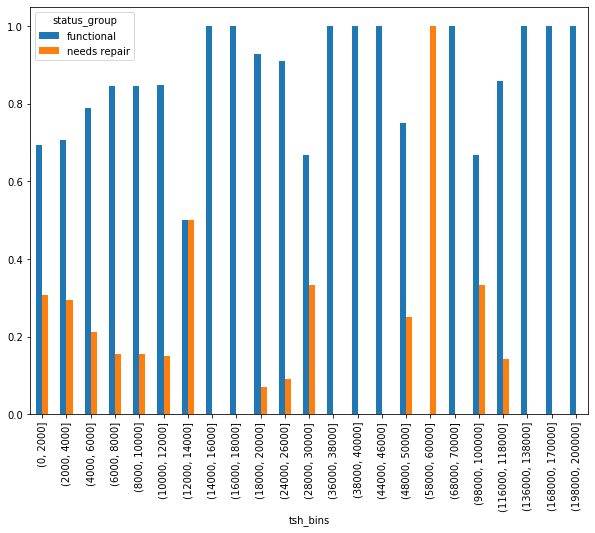

In [25]:
tshbins = range(0, df.amount_tsh.max(), 2000)
df_b['tsh_bins'] = pd.cut(df_b.amount_tsh, bins=tshbins)
tshs = pd.crosstab(df_b.tsh_bins,df_b.status_group,normalize='index')
tshs.plot(kind='bar',figsize=(10,7.50),fontsize=10)
tshs

### Feature: Quality

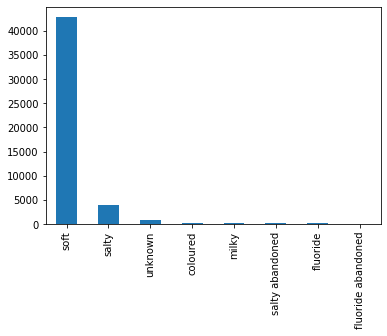

In [21]:
df.water_quality.value_counts().plot(kind='bar')

status_group,functional,needs repair
water_quality,,
fluoride,0.775000,0.225000
soft,0.568008,0.431992
milky,0.565217,0.434783
coloured,0.509375,0.490625
salty abandoned,0.456897,0.543103
salty,0.443343,0.556657
fluoride abandoned,0.307692,0.692308
unknown,0.104545,0.895455


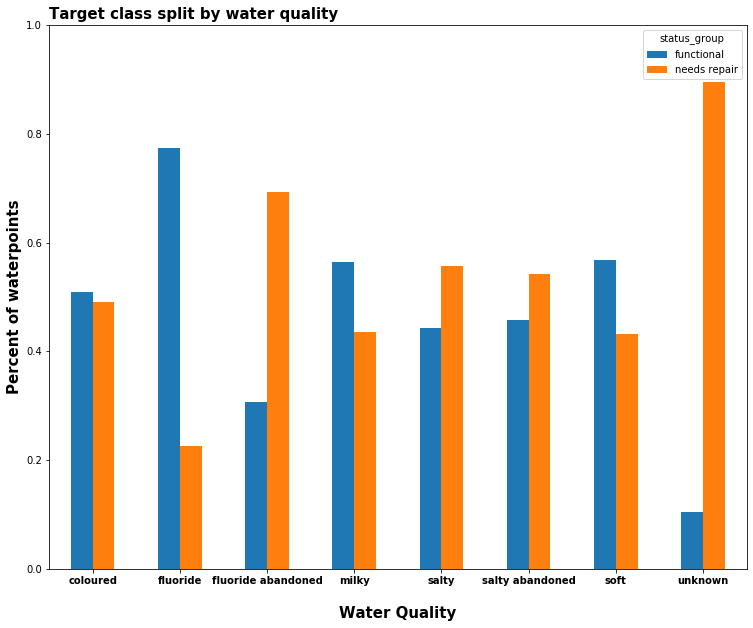

In [23]:
watqb = pd.crosstab(df_b.water_quality,df_b.status_group,normalize='index')

wq = watqb.plot(kind='bar',figsize=(12.5,10),fontsize=10,rot=0)
plt.ylabel('Percent of waterpoints',fontsize=15,fontweight='bold')
plt.xlabel('Water Quality',fontsize=15,wrap=True,labelpad = 20,fontweight='bold')
plt.xticks(fontweight='bold')
plt.title('Target class split by water quality',fontsize=15,loc='left',fontweight='bold')
plt.ylim([0,1])
plt.savefig('../images/water_status.png',bbox_inches='tight',pad_inches=0.5)
watqb.sort_values('functional',ascending=False)

What do all these unknown water quality waterpoints mean?

In [26]:
df_wq = df_b[df_b['water_quality'] == 'unknown']

In [336]:
df_wq.amount_tsh.value_counts()

0       747
20       28
500      19
2000     15
1000     14
50       13
7500      8
10        8
100       7
200       5
3000      5
5000      3
30        2
25        2
300       1
250       1
5         1
1200      1
Name: amount_tsh, dtype: int64

so unknown water quality does **not** necessarily mean the waterpoint isnt operational, just that the quality could not or was not identified. 

### Feature: Quantity

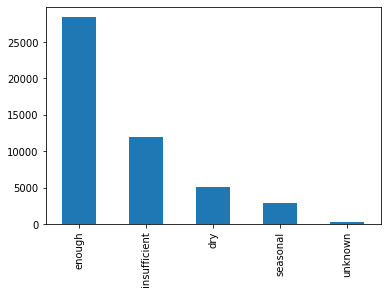

In [29]:
df.quantity.value_counts().plot(kind='bar')

status_group,functional,needs repair
quantity,,
enough,0.655901,0.344099
seasonal,0.569263,0.430737
insufficient,0.522561,0.477439
unknown,0.206897,0.793103
dry,0.024687,0.975313


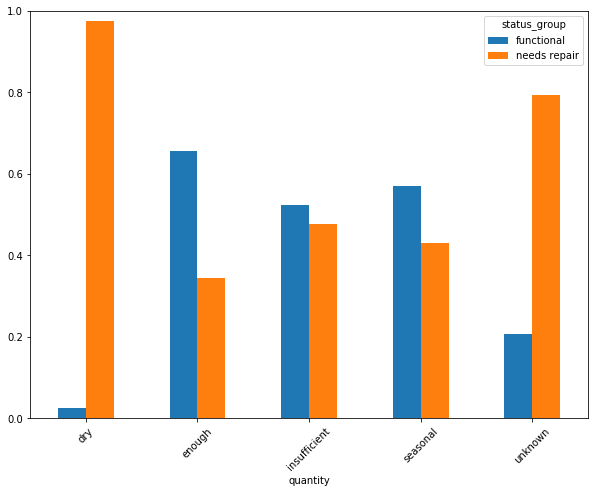

In [265]:
quantb = pd.crosstab(df_b.quantity,df_b.status_group,normalize='index')
quantb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
plt.ylim([0,1])

quantb.sort_values('functional',ascending=False)

### Feature: Source

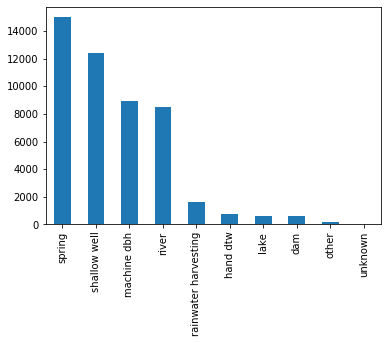

In [31]:
df.source.value_counts().plot(kind='bar')

(0, 1)

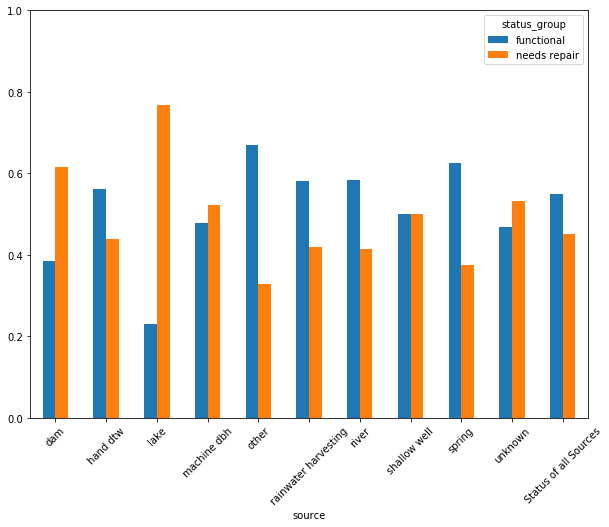

In [245]:
srcb = pd.crosstab(df_b.source,df_b.status_group,normalize='index',margins=True,margins_name='Status of all Sources')
srcb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)


plt.ylim([0,1])


### Source Class

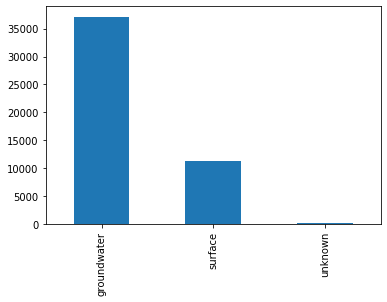

In [34]:
df.source_class.value_counts().plot(kind='bar')

status_group,functional,needs repair
source_class,,
unknown,0.640187,0.359813
surface,0.554916,0.445084
All,0.549218,0.450782
groundwater,0.546960,0.453040


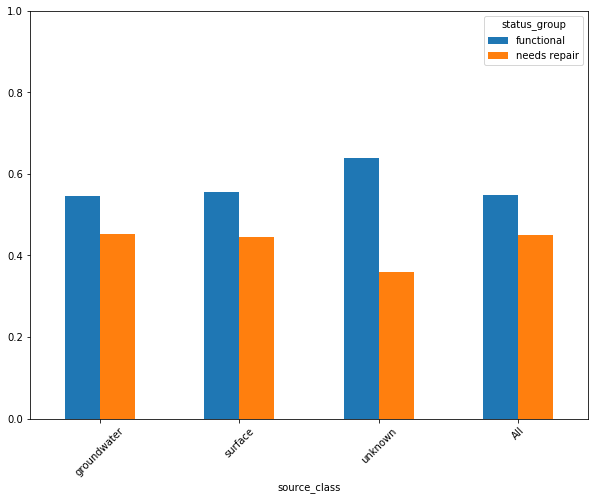

In [247]:
srccb = pd.crosstab(df_b.source_class,df_b.status_group,margins=True,normalize='index')#
srccb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])
#plt.show()
srccb.sort_values('functional',ascending=False)

### Feature: Basin

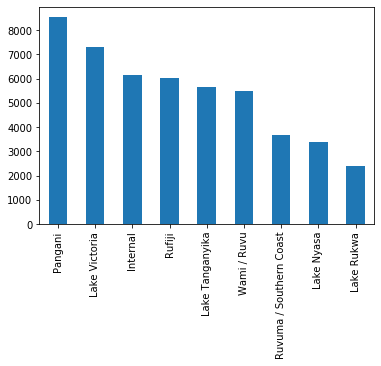

In [37]:
df.basin.value_counts().plot(kind='bar')

status_group,functional,needs repair
basin,,
Lake Nyasa,0.692239,0.307761
Rufiji,0.668380,0.331620
Pangani,0.602927,0.397073
Internal,0.601625,0.398375
All,0.549218,0.450782
Wami / Ruvu,0.510386,0.489614
Lake Victoria,0.493102,0.506898
Lake Tanganyika,0.477132,0.522868
Lake Rukwa,0.411324,0.588676


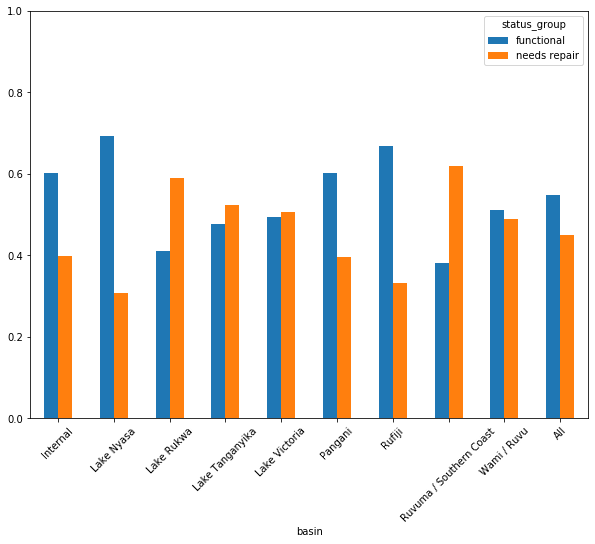

In [248]:
basin = pd.crosstab([df_b.basin],df_b.status_group,margins=True,normalize='index')#
basin.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

basin.sort_values('functional',ascending=False)

do they have different water?

water_quality,coloured,fluoride,fluoride abandoned,milky,salty,salty abandoned,soft,unknown
basin,,,,,,,,
Internal,0.010723,0.014297,0.001137,0.007149,0.083834,0.005524,0.869699,0.007636
Lake Nyasa,0.001481,0.000889,0.000000,0.000000,0.001777,0.000000,0.983709,0.012145
Lake Rukwa,0.003331,0.000000,0.000000,0.006661,0.073272,0.000000,0.893838,0.022898
Lake Tanganyika,0.010065,0.000353,0.000177,0.019954,0.039025,0.000177,0.912590,0.017658
Lake Victoria,0.005600,0.000546,0.000137,0.006283,0.074170,0.020352,0.857123,0.035787
Pangani,0.004098,0.006557,0.000117,0.000820,0.067213,0.000585,0.914286,0.006323
Rufiji,0.006135,0.000000,0.000166,0.004145,0.024706,0.000663,0.960537,0.003648
Ruvuma / Southern Coast,0.006259,0.000544,0.000000,0.008980,0.149660,0.005442,0.789116,0.040000
Wami / Ruvu,0.008746,0.000911,0.000364,0.002733,0.218841,0.003462,0.737245,0.027697


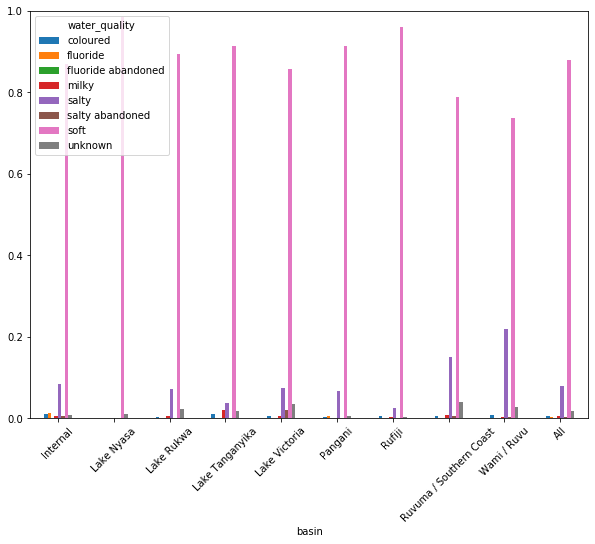

In [30]:
basin2 = pd.crosstab([df_b.basin],df_b.water_quality,margins=True,normalize='index')#
basin2.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

basin2

## Feature Group: Waterpoint

### Feature: Waterpoint Age

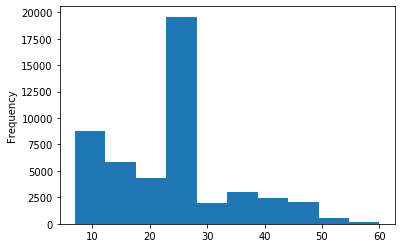

In [82]:
df.age.plot(kind='hist') #knn? 

In [32]:
mybins = range(0, df_b.age.max(), 10)
df_b['age_bucket'] = pd.cut(df_b.age, bins=mybins)

status_group,functional,needs repair
age_bucket,,
"(0, 10]",0.733616,0.266384
"(10, 20]",0.661978,0.338022
"(20, 30]",0.519066,0.480934
"(30, 40]",0.421561,0.578439
"(40, 50]",0.335172,0.664828


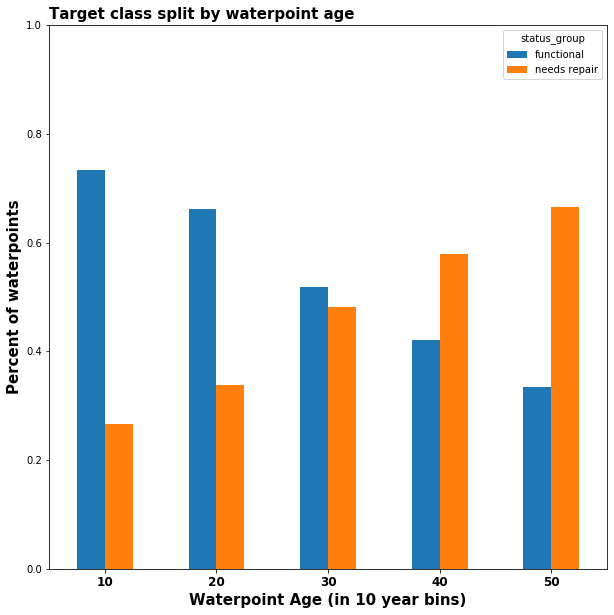

In [33]:
ages_b = pd.crosstab(df_b.age_bucket,df_b.status_group,normalize='index')
ages_b.plot(kind='bar',figsize=(10,10),fontsize=10,rot=0)

plt.ylabel('Percent of waterpoints',fontsize=15,fontweight='bold')
plt.xlabel('Waterpoint Age (in 10 year bins)',fontsize=15,fontweight='bold')
plt.title('Target class split by waterpoint age',fontsize=15,loc='left',fontweight='bold')
t11 = ['10','20','30','40','50']
plt.xticks(range(len(t11)), t11, size='large',fontweight='bold')
plt.ylim([0,1])

plt.savefig('../images/age_status.png',bbox_inches='tight',pad_inches=0.5)
ages_b

### Feature: Waterpoint Type

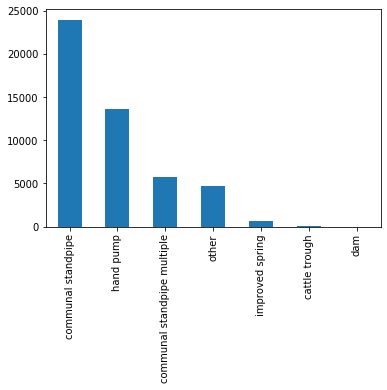

In [154]:
df.waterpoint_type.value_counts().plot(kind='bar')

In [157]:
df_c = df_b[df_b['waterpoint_type'] == 'communal standpipe'].copy()
wpttpbc = pd.crosstab([df_c.waterpoint_type,df_c.age_bucket],df_c.status_group,normalize='index')
wpttpbc

status_group                   functional  needs repair
waterpoint_type    age_bucket                          
communal standpipe (0, 10]       0.815657      0.184343
                   (10, 20]      0.747739      0.252261
                   (20, 30]      0.543739      0.456261
                   (30, 40]      0.570179      0.429821
                   (40, 50]      0.441765      0.558235

status_group                   functional  needs repair
waterpoint_type    age_bucket                          
communal standpipe (0, 10]       0.815657      0.184343
                   (10, 20]      0.747739      0.252261
                   (30, 40]      0.570179      0.429821
                   (20, 30]      0.543739      0.456261
                   (40, 50]      0.441765      0.558235

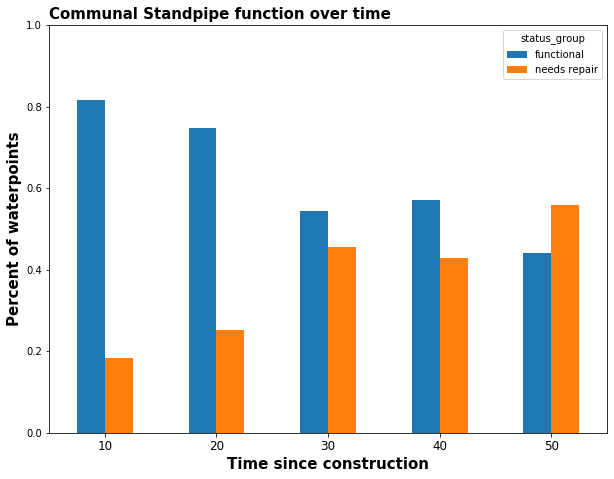

In [287]:
wpttpbc.plot(kind='bar',figsize=(10,7.5),rot=0)
plt.ylabel('Percent of waterpoints',fontsize=15,fontweight='bold')
plt.xlabel('Time since construction',fontsize=15,fontweight='bold')
t11 = ['10','20','30','40','50']
plt.xticks(range(len(t11)), t11, size='large')
plt.title('Communal Standpipe function over time',fontsize=15,loc='left',fontweight='bold')
plt.ylim([0,1])

plt.savefig('../images/commstdp_status.png',bbox_inches='tight',pad_inches=0.5)


wpttpbc.sort_values('functional',ascending=False)

### Feature: Extraction Type

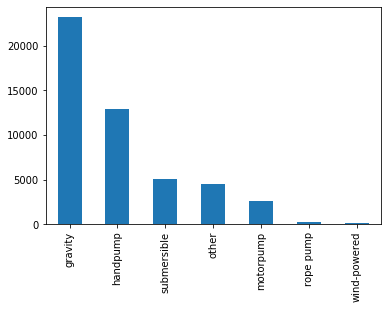

In [51]:
df.extraction_type_class.value_counts().plot(kind='bar')

status_group,functional,needs repair
extraction_type_class,,
rope pump,0.636792,0.363208
handpump,0.629644,0.370356
gravity,0.609020,0.390980
submersible,0.521346,0.478654
wind-powered,0.413462,0.586538
motorpump,0.394275,0.605725
other,0.134963,0.865037


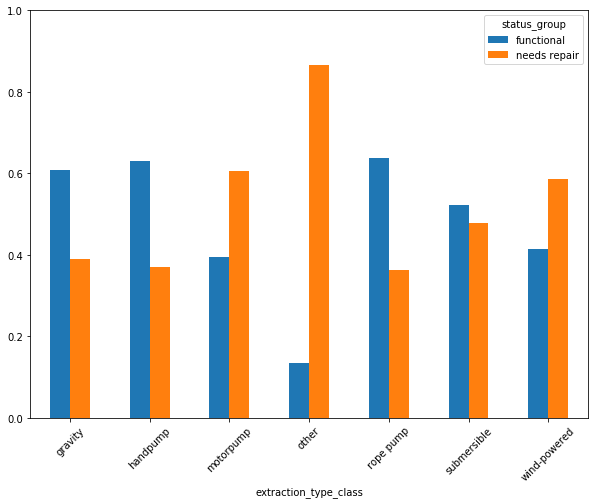

In [256]:
exttpb = pd.crosstab(df_b.extraction_type_class,df_b.status_group,normalize='index')
exttpb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

plt.savefig('../images/extract_status.png')
exttpb.sort_values('functional',ascending=False)

## Feature Group: Governance

### Feature: Permit

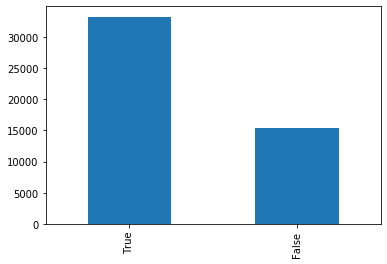

In [54]:
df.permit.value_counts().plot(kind='bar')

status_group,functional,needs repair
permit,,
True,0.568521,0.431479
False,0.507301,0.492699


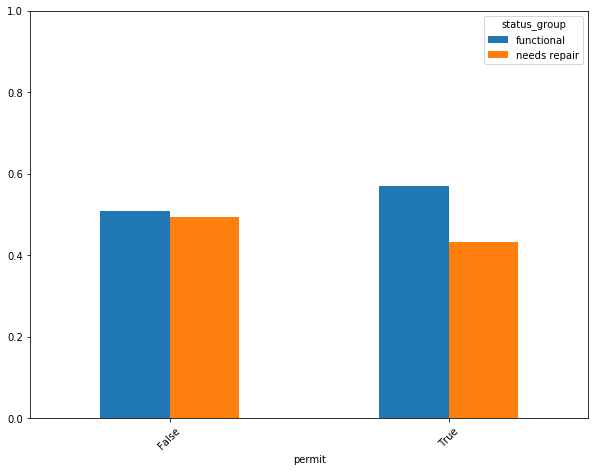

In [257]:
permitb = pd.crosstab(df_b.permit,df_b.status_group,normalize='index')
permitb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

plt.savefig('../images/permit_status.png')
permitb.sort_values('functional',ascending=False)

### Feature: Public Meeting

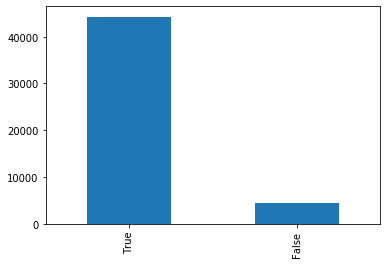

In [57]:
df.public_meeting.value_counts().plot(kind='bar')

status_group,functional,needs repair
public_meeting,,
True,0.562784,0.437216
False,0.410994,0.589006


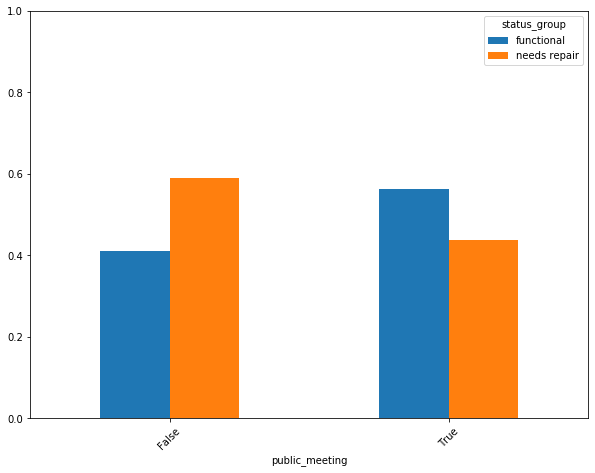

In [258]:
meetb = pd.crosstab(df_b.public_meeting,df_b.status_group,normalize='index')
meetb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

meetb.sort_values('functional',ascending=False)

### Feature: Funder

In [117]:
top10funders = df['funder'].value_counts().index.tolist()[:11]
top10funders

['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Kkkt',
 'World Bank',
 'World Vision',
 'Unicef',
 'Rwssp',
 'District Council',
 'Tasaf',
 'Private Individual']

status_group,functional,needs repair
funder,,
Private Individual,0.843546,0.156454
Rwssp,0.593516,0.406484
World Vision,0.589080,0.410920
Unicef,0.589055,0.410945
Danida,0.570890,0.429110
Tasaf,0.559085,0.440915
Kkkt,0.559080,0.440920
District Council,0.456929,0.543071
Hesawa,0.448524,0.551476


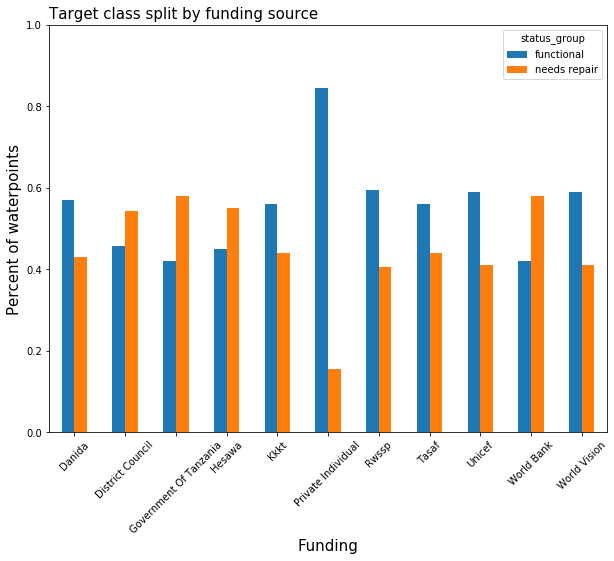

In [259]:
df_f = df_b[df_b['funder'].isin(top10funders)]
funders = pd.crosstab(df_f.funder,df_f.status_group,normalize='index')
funders.plot(kind='bar',figsize=(10,7.5),rot=45)


plt.ylabel('Percent of waterpoints',fontsize=15)
plt.xlabel('Funding',fontsize=15)
plt.title('Target class split by funding source',fontsize=15,loc='left')
plt.ylim([0,1])

plt.savefig('../images/funders_status.png',bbox_inches='tight',pad_inches=0.5)


funders.sort_values('functional',ascending=False)

In [62]:
priv = df_b[df_b['funder'] == 'Private Individual']

In [63]:
priv.age.value_counts(bins=10) ##most privately funded waterpoints were built in the last 20 years

(7.947, 13.2]    390
(13.2, 18.4]     227
(18.4, 23.6]     114
(28.8, 34.0]       9
(44.4, 49.6]       8
(34.0, 39.2]       8
(23.6, 28.8]       7
(54.8, 60.0]       2
(39.2, 44.4]       2
(49.6, 54.8]       0
Name: age, dtype: int64

In [64]:
priv.extraction_type_class.value_counts()

submersible     439
gravity         192
motorpump        48
handpump         47
other            34
wind-powered      4
rope pump         3
Name: extraction_type_class, dtype: int64

In [65]:
df_b.extraction_type_class.value_counts()

gravity         23170
handpump        12920
submersible      5083
other            4542
motorpump        2620
rope pump         212
wind-powered      104
Name: extraction_type_class, dtype: int64

### Feature: Installer

In [66]:
df.installer.value_counts()

DWE                    14670
Government              1438
Commu                   1059
RWE                     1032
KKKT                     885
                       ...  
SINGIDA  YETU              1
Mwananchi Engineeri        1
Rusumo Game reserve        1
Ongan                      1
Morovian Church            1
Name: installer, Length: 1799, dtype: int64

In [91]:
top10installers = df.installer.value_counts().index.tolist()[:11]
top10installers

['DWE',
 'Government',
 'Commu',
 'RWE',
 'KKKT',
 'DANIDA',
 'TCRS',
 'Central government',
 'CES',
 'Hesawa',
 'DANID']

status_group,functional,needs repair
installer,,
CES,0.881967,0.118033
DANID,0.780797,0.219203
Commu,0.682720,0.317280
Hesawa,0.617857,0.382143
DANIDA,0.580720,0.419280
DWE,0.550511,0.449489
KKKT,0.466667,0.533333
TCRS,0.399701,0.600299
Government,0.276773,0.723227


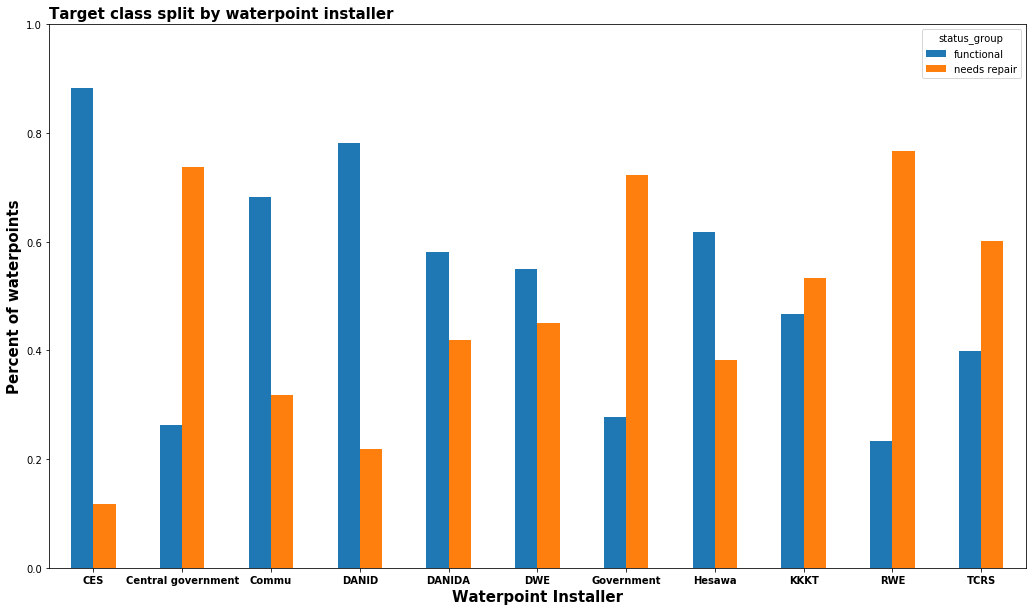

In [332]:
df_i = df_b[df_b['installer'].isin(top10installers)]
installers = pd.crosstab([df_i.installer],df_i.status_group,normalize='index')
installers.plot(kind='bar',figsize=(17.5,10),rot=0)

plt.ylabel('Percent of waterpoints',fontsize=15,fontweight='bold')
plt.xlabel('Waterpoint Installer',fontsize=15,fontweight='bold')
plt.xticks(fontweight='bold')
plt.title('Target class split by waterpoint installer',fontsize=15,loc='left',fontweight='bold')
plt.ylim([0,1])


plt.savefig('../images/allinstallers_status.png',bbox_inches='tight',pad_inches=0.5)
installers.sort_values('functional',ascending=False)

status_group,functional,needs repair
installer,,
ACRA,0.978339,0.021661
Magadini-Makiwaru wa,0.977143,0.022857
Dmdd,0.964789,0.035211
Co,0.945455,0.054545
St,0.944444,0.055556
Oikos E .Africa,0.937500,0.062500
Lawatefuka water sup,0.933333,0.066667
DAWASCO,0.921875,0.078125
Losaa-Kia water supp,0.919355,0.080645


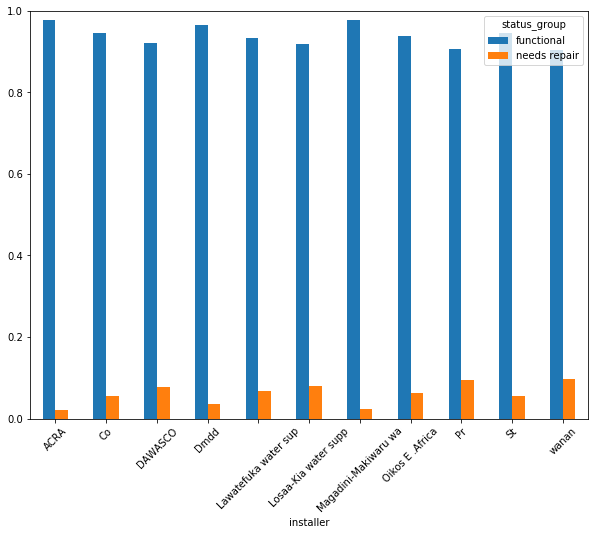

In [261]:
top100installers = df.installer.value_counts().index.tolist()[:135]
df_i2 = df_b[df_b['installer'].isin(top100installers)]
installers100 = pd.crosstab([df_i2.installer],df_i2.status_group,normalize='index')
installers100 = installers100[installers100['functional'] > 0.90]
installers100.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

plt.savefig('../images/topinstallers_status.png')
installers100.sort_values('functional',ascending=False)

In [70]:
installers90club = installers100.index.tolist()
inst90clb = df_b[df_b['installer'].isin(installers90club)]

In [71]:
inst90clb.installer.value_counts()

Dmdd                    284
ACRA                    277
Lawatefuka water sup    180
Magadini-Makiwaru wa    175
Oikos E .Africa          80
DAWASCO                  64
Losaa-Kia water supp     62
Co                       55
St                       54
Pr                       53
wanan                    52
Name: installer, dtype: int64

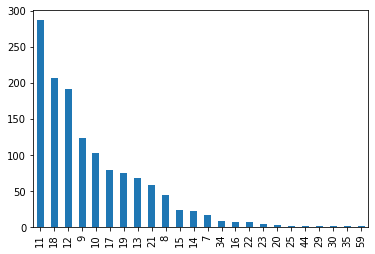

In [72]:
inst90clb.age.value_counts().plot(kind='bar')

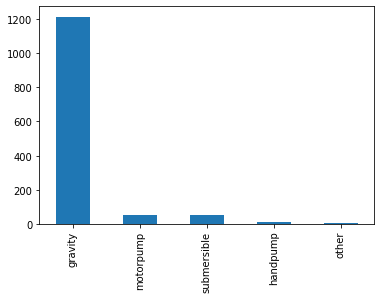

In [73]:
inst90clb.extraction_type_class.value_counts().plot(kind='bar')

(<matplotlib.axes._subplots.AxesSubplot at 0x1a27901828>,)

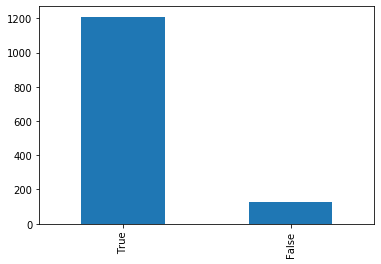

In [74]:
inst90clb.permit.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a295b58d0>,)

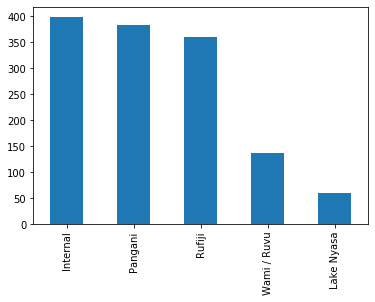

In [75]:
inst90clb.basin.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a25988278>,)

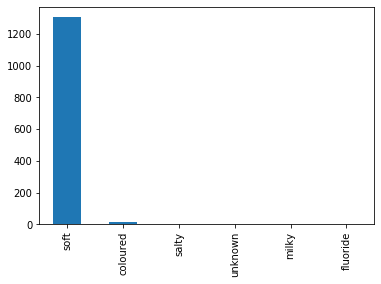

In [76]:
inst90clb.water_quality.value_counts().plot(kind='bar'), #NOTE: the most effective installers may be most effective because of the water quality

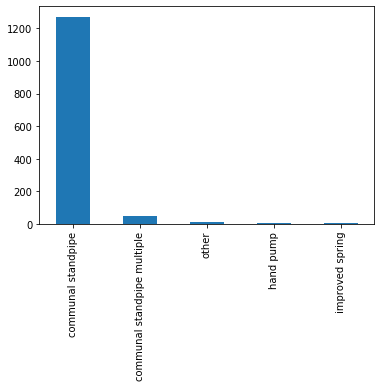

In [77]:
inst90clb.waterpoint_type.value_counts().plot(kind='bar')

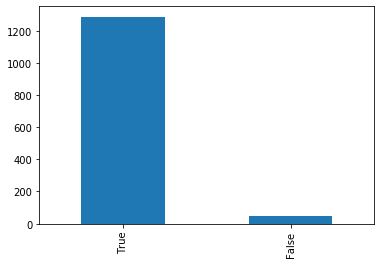

In [78]:
inst90clb.public_meeting.value_counts().plot(kind='bar')

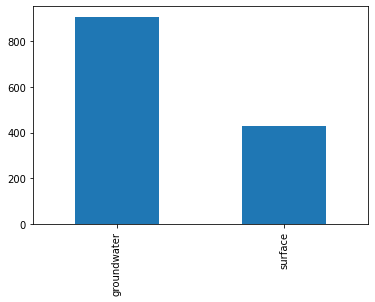

In [79]:
inst90clb.source_class.value_counts().plot(kind='bar')

In [80]:
inst90clb.population.mean()

135.23877245508982

Lets take a look at the other end, of installers who have completed 50 projects, who have the lowest function frequency?

status_group,functional,needs repair
installer,,
District council,0.240933,0.759067
RWE,0.233527,0.766473
GOVER,0.232000,0.768000
DA,0.226190,0.773810
Finwater,0.206897,0.793103
Halmashauri ya wilaya sikonge,0.204082,0.795918
Adra/Community,0.200000,0.800000
Water board,0.185185,0.814815
FinW,0.182692,0.817308


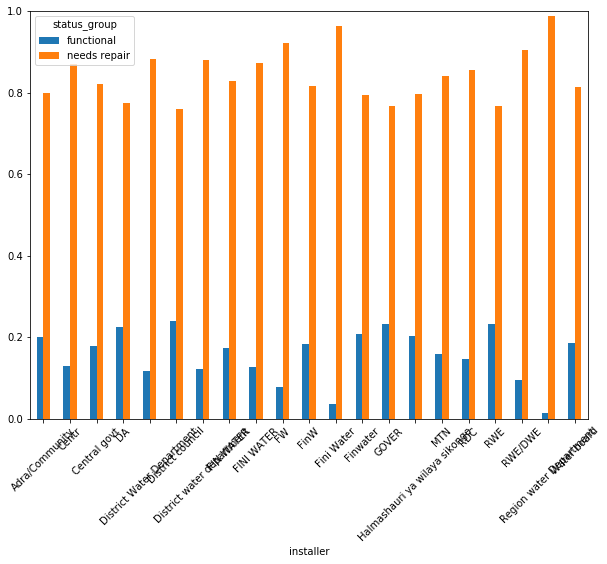

In [262]:
atleast50 = df.installer.value_counts().index.tolist()[:135]
df_i3 = df_b[df_b['installer'].isin(atleast50)]
bottominst = pd.crosstab([df_i3.installer],df_i2.status_group,normalize='index')
bottominst = bottominst[bottominst['functional'] < 0.25]
bottominst.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.ylim([0,1])

bottominst.sort_values('functional',ascending=False)

In [82]:
installers25club = bottominst.index.tolist()
inst25clb = df_b[df_b['installer'].isin(installers25club)]

In [83]:
inst25clb.age.mean()

33.76490577695397

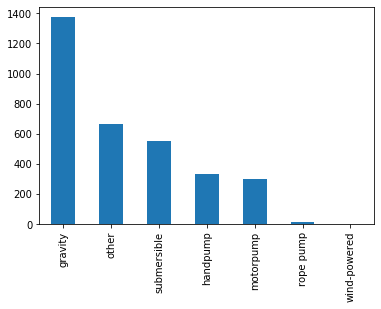

In [84]:
inst25clb.extraction_type_class.value_counts().plot(kind='bar')

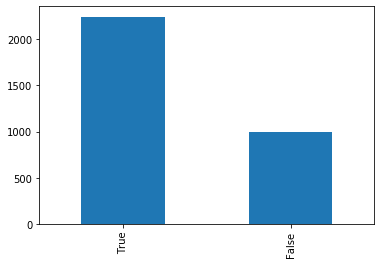

In [85]:
inst25clb.permit.value_counts().plot(kind='bar')

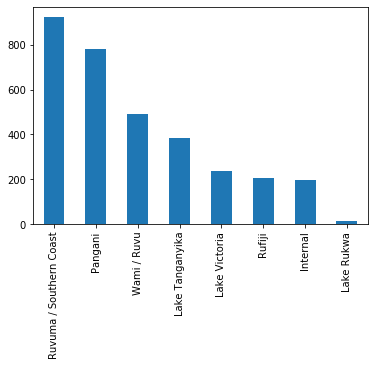

In [86]:
inst25clb.basin.value_counts().plot(kind='bar')

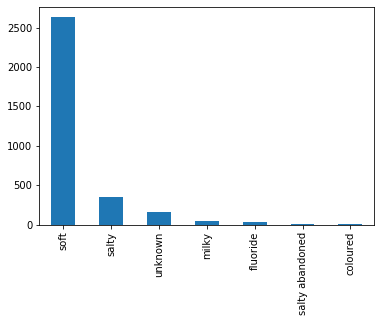

In [87]:
inst25clb.water_quality.value_counts().plot(kind='bar')

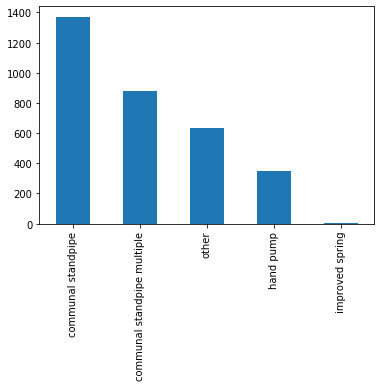

In [88]:
inst25clb.waterpoint_type.value_counts().plot(kind='bar')

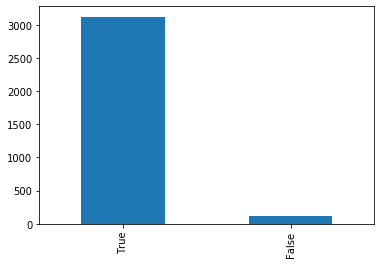

In [89]:
inst25clb.public_meeting.value_counts().plot(kind='bar')

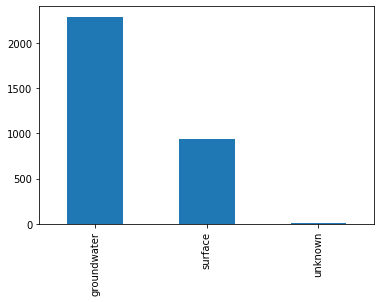

In [90]:
inst25clb.source_class.value_counts().plot(kind='bar')

It seems there isn't too much a different to be seen by EDA, but the model should help